In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("Superstoredataset.csv")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2020-152156,08/11/2020,11/11/2020,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2020-152156,08/11/2020,11/11/2020,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2020-138688,12/06/2020,16/06/2020,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2019-108966,11/10/2019,18/10/2019,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2019-108966,11/10/2019,18/10/2019,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          9994 non-null   int64  
 1   Order ID        9994 non-null   object 
 2   Order Date      9994 non-null   object 
 3   Ship Date       9994 non-null   object 
 4   Ship Mode       9994 non-null   object 
 5   Customer ID     9994 non-null   object 
 6   Customer Name   9994 non-null   object 
 7   Segment         9994 non-null   object 
 8   Country/Region  9994 non-null   object 
 9   City            9994 non-null   object 
 10  State           9994 non-null   object 
 11  Postal Code     9983 non-null   float64
 12  Region          9994 non-null   object 
 13  Product ID      9994 non-null   object 
 14  Category        9994 non-null   object 
 15  Sub-Category    9994 non-null   object 
 16  Product Name    9994 non-null   object 
 17  Sales           9994 non-null   f

In [4]:
df['Order Date'] = pd.to_datetime(df['Order Date'],format = '%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format = '%d/%m/%Y')
print(df.dtypes)

Row ID                     int64
Order ID                  object
Order Date        datetime64[ns]
Ship Date         datetime64[ns]
Ship Mode                 object
Customer ID               object
Customer Name             object
Segment                   object
Country/Region            object
City                      object
State                     object
Postal Code              float64
Region                    object
Product ID                object
Category                  object
Sub-Category              object
Product Name              object
Sales                    float64
Quantity                   int64
Discount                 float64
Profit                   float64
dtype: object


In [5]:
df.drop(['Row ID', 'Order ID','Ship Mode','Segment','Customer Name','Country/Region','Product ID','Product Name','Postal Code'],axis =1, inplace = True)

In [6]:
category_col = ['City', 'State', 'Region', 'Category', 'Sub-Category']

# Get the number of distinct values for each specified column
distinct_values = df[category_col].nunique()
print(distinct_values)

City            531
State            49
Region            4
Category          3
Sub-Category     17
dtype: int64


In [7]:
#drop city to avoid high-dimensional one-hot encoding
df.drop(['City'], axis = 1, inplace = True)
df.head()

,Order Date,Ship Date,Customer ID,State,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,2020-11-08,2020-11-11,CG-12520,Kentucky,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,2020-11-08,2020-11-11,CG-12520,Kentucky,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,2020-06-12,2020-06-16,DV-13045,California,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,2019-10-11,2019-10-18,SO-20335,Florida,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,2019-10-11,2019-10-18,SO-20335,Florida,South,Office Supplies,Storage,22.3680,2,0.20,2.5164


In [8]:
#check duplicate column
duplicate_rows_df = df[df.duplicated()]

#shape[0] is used to get the count of rows,  shape[1]) is the number of columns
print(f"Number of duplicate rows: {duplicate_rows_df.shape[0]}")

Number of duplicate rows: 1


In [9]:
df_cleaned = df.drop_duplicates()
df_cleaned.shape

(9993, 11)

In [10]:
reference_date = df_cleaned['Order Date'].max()
recency_df = df_cleaned.groupby('Customer ID')['Order Date'].max().reset_index()
recency_df.columns = ['Customer ID', 'Last Purchase Date']
recency_df['Recency']= (reference_date - recency_df['Last Purchase Date']).dt.days
print(recency_df)

frequency_df = df_cleaned.groupby('Customer ID')['Order Date'].count().reset_index()
frequency_df.columns = ['Customer ID', 'Frequency']
print(frequency_df)

monetary_df = df_cleaned.groupby('Customer ID')['Sales'].sum().reset_index()
monetary_df.columns = ['Customer ID', 'Monetary']
print(monetary_df)

profit_df = df_cleaned.groupby('Customer ID')['Profit'].sum().reset_index()
profit_df.columns = ['Customer ID', 'Profit']
print(profit_df)

RFM_df = recency_df.merge(frequency_df, on = 'Customer ID').merge(monetary_df, on = 'Customer ID').merge(profit_df, on = 'Customer ID')
RFM_df['AvgPurchaseValue'] = RFM_df['Monetary']/RFM_df['Frequency']

total_order_number = RFM_df['Frequency'].sum()
print(total_order_number)
total_unique_customers = RFM_df.shape[0]

Purchase_frequency = total_order_number/total_unique_customers


total_order_number_greater_than_1 = RFM_df[RFM_df['Frequency'] > 1].shape[0]

total_unique_customers = RFM_df.shape[0]
retention_rate = total_order_number_greater_than_1 / total_unique_customers
churn_rate = 1 - retention_rate
print(f"Churn Rate: {churn_rate}")

RFM_df['profit_margin'] = RFM_df['Profit']/RFM_df['Monetary']

RFM_df['CLV'] = ((RFM_df['AvgPurchaseValue']*Purchase_frequency)/churn_rate)* RFM_df['profit_margin']
RFM_df

    Customer ID Last Purchase Date  Recency
0      AA-10315         2021-06-29      184
1      AA-10375         2021-12-11       19
2      AA-10480         2021-04-15      259
3      AA-10645         2021-11-05       55
4      AB-10015         2020-11-10      415
..          ...                ...      ...
788    XP-21865         2021-11-17       43
789    YC-21895         2021-12-26        4
790    YS-21880         2021-12-21        9
791    ZC-21910         2021-11-06       54
792    ZD-21925         2021-06-11      202

[793 rows x 3 columns]
    Customer ID  Frequency
0      AA-10315         11
1      AA-10375         15
2      AA-10480         12
3      AA-10645         18
4      AB-10015          6
..          ...        ...
788    XP-21865         28
789    YC-21895          8
790    YS-21880         12
791    ZC-21910         31
792    ZD-21925          9

[793 rows x 2 columns]
    Customer ID  Monetary
0      AA-10315  5563.560
1      AA-10375  1056.390
2      AA-10480  1790.

,Customer ID,Last Purchase Date,Recency,Frequency,Monetary,Profit,AvgPurchaseValue,profit_margin,CLV
0,AA-10315,2021-06-29,184,11,5563.560,-362.8825,505.778182,-0.065225,-65932.451318
1,AA-10375,2021-12-11,19,15,1056.390,277.3824,70.426000,0.262576,36958.430976
2,AA-10480,2021-04-15,259,12,1790.512,435.8274,149.209333,0.243409,72587.053470
3,AA-10645,2021-11-05,55,18,5086.935,857.8033,282.607500,0.168629,95244.759743
4,AB-10015,2020-11-10,415,6,886.156,129.3465,147.692667,0.145964,43085.319150
...,...,...,...,...,...,...,...,...,...
788,XP-21865,2021-11-17,43,28,2374.658,621.2300,84.809214,0.261608,44342.509929
789,YC-21895,2021-12-26,4,8,5454.350,1305.6290,681.793750,0.239374,326178.764925
790,YS-21880,2021-12-21,9,12,6720.444,1778.2923,560.037000,0.264609,296174.582565
791,ZC-21910,2021-11-06,54,31,8025.707,-1032.1490,258.893774,-0.128605,-66543.644884


In [11]:
# preserve the distribution of the data ( skewness is retained: min-max scaler
numerical_cols = ['Recency', 'Frequency', 'Monetary', 'Profit', 'AvgPurchaseValue', 'CLV']
scaler = MinMaxScaler()
CLV_scaled = scaler.fit_transform(RFM_df[numerical_cols])
CLV_scaled_df = pd.DataFrame(CLV_scaled, columns=['Recency', 'Frequency', 'Monetary','Profit','AvgPurchaseValue','CLV'])
print(CLV_scaled_df.head())

    Recency  Frequency  Monetary    Profit  AvgPurchaseValue       CLV
0  0.157940   0.277778  0.222010  0.401308          0.287820  0.473679
1  0.016309   0.388889  0.041998  0.442331          0.038888  0.508354
2  0.222318   0.305556  0.071318  0.452482          0.083936  0.520361
3  0.047210   0.472222  0.202974  0.479519          0.160212  0.527996
4  0.356223   0.138889  0.035199  0.432846          0.083068  0.510419


In [12]:
CLV_scaled_df.drop(['Profit'], axis = 1, inplace = True)

CLV_scaled_df

,Recency,Frequency,Monetary,AvgPurchaseValue,CLV
0,0.157940,0.277778,0.222010,0.287820,0.473679
1,0.016309,0.388889,0.041998,0.038888,0.508354
2,0.222318,0.305556,0.071318,0.083936,0.520361
3,0.047210,0.472222,0.202974,0.160212,0.527996
4,0.356223,0.138889,0.035199,0.083068,0.510419
...,...,...,...,...,...
788,0.036910,0.750000,0.094648,0.047112,0.510842
789,0.003433,0.194444,0.217648,0.388465,0.605822
790,0.007725,0.305556,0.268214,0.318845,0.595710
791,0.046352,0.833333,0.320345,0.146653,0.473473


In [13]:
#the goal is to segment customers based on their overall contribution and purchasing behaviour, so including the CLV
# Apply K-means
kmeans = KMeans(n_clusters=4, random_state=42)  
CLV_scaled_df['Cluster'] = kmeans.fit_predict(CLV_scaled_df)

print(CLV_scaled_df.head())

    Recency  Frequency  Monetary  AvgPurchaseValue       CLV  Cluster
0  0.157940   0.277778  0.222010          0.287820  0.473679        3
1  0.016309   0.388889  0.041998          0.038888  0.508354        1
2  0.222318   0.305556  0.071318          0.083936  0.520361        1
3  0.047210   0.472222  0.202974          0.160212  0.527996        0
4  0.356223   0.138889  0.035199          0.083068  0.510419        2


In [14]:
def categorize_cluster(cluster_id):
    # Define cluster characteristics manually based on descriptive analysis
    if cluster_id == 0:
        return 'Medium to High'
    elif cluster_id == 1:
        return 'Medium to Low'
    elif cluster_id == 2:
        return 'Low'
    elif cluster_id == 3:
        return 'High'


CLV_scaled_df['Cluster'] = CLV_scaled_df['Cluster'].map(categorize_cluster)

customer_ids = RFM_df['Customer ID']
CLV_scaled_df.insert(0, 'Customer ID', customer_ids)

# Display the updated CLV_scaled_df
print(CLV_scaled_df.head())


cluster_df = CLV_scaled_df[['Customer ID','Cluster']]

merged_cluster_df = df_cleaned.merge(cluster_df, on='Customer ID', how='left')
print("Merged_cluster_df:")
merged_cluster_df

  Customer ID   Recency  Frequency  Monetary  AvgPurchaseValue       CLV  \
0    AA-10315  0.157940   0.277778  0.222010          0.287820  0.473679   
1    AA-10375  0.016309   0.388889  0.041998          0.038888  0.508354   
2    AA-10480  0.222318   0.305556  0.071318          0.083936  0.520361   
3    AA-10645  0.047210   0.472222  0.202974          0.160212  0.527996   
4    AB-10015  0.356223   0.138889  0.035199          0.083068  0.510419   

          Cluster  
0            High  
1   Medium to Low  
2   Medium to Low  
3  Medium to High  
4             Low  
Merged_cluster_df:


,Order Date,Ship Date,Customer ID,State,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Cluster
0,2020-11-08,2020-11-11,CG-12520,Kentucky,South,Furniture,Bookcases,261.9600,2,0.00,41.9136,Low
1,2020-11-08,2020-11-11,CG-12520,Kentucky,South,Furniture,Chairs,731.9400,3,0.00,219.5820,Low
2,2020-06-12,2020-06-16,DV-13045,California,West,Office Supplies,Labels,14.6200,2,0.00,6.8714,Medium to Low
3,2019-10-11,2019-10-18,SO-20335,Florida,South,Furniture,Tables,957.5775,5,0.45,-383.0310,Medium to Low
4,2019-10-11,2019-10-18,SO-20335,Florida,South,Office Supplies,Storage,22.3680,2,0.20,2.5164,Medium to Low
...,...,...,...,...,...,...,...,...,...,...,...,...
9988,2018-01-21,2018-01-23,TB-21400,Florida,South,Furniture,Furnishings,25.2480,3,0.20,4.1028,High
9989,2021-02-26,2021-03-03,DB-13060,California,West,Furniture,Furnishings,91.9600,2,0.00,15.6332,Medium to Low
9990,2021-02-26,2021-03-03,DB-13060,California,West,Technology,Phones,258.5760,2,0.20,19.3932,Medium to Low
9991,2021-02-26,2021-03-03,DB-13060,California,West,Office Supplies,Paper,29.6000,4,0.00,13.3200,Medium to Low


In [15]:
customer_features = CLV_scaled_df[['Customer ID', 'Recency', 'Frequency', 'Monetary',
                                   'AvgPurchaseValue', 'CLV', 'Cluster']]

# Perform a left join on 'Customer ID'
CLV_combine_df = merged_cluster_df.merge(customer_features, on='Customer ID', how='left')

# Verify the resulting DataFrame
print("Final Combined DataFrame:")
print(CLV_combine_df.head())

# Verify the shape to ensure 9,993 rows
print("Shape of Final Combined DataFrame:", CLV_combine_df.shape)

Final Combined DataFrame:
  Order Date  Ship Date Customer ID       State Region         Category  \
0 2020-11-08 2020-11-11    CG-12520    Kentucky  South        Furniture   
1 2020-11-08 2020-11-11    CG-12520    Kentucky  South        Furniture   
2 2020-06-12 2020-06-16    DV-13045  California   West  Office Supplies   
3 2019-10-11 2019-10-18    SO-20335     Florida  South        Furniture   
4 2019-10-11 2019-10-18    SO-20335     Florida  South  Office Supplies   

  Sub-Category     Sales  Quantity  Discount    Profit      Cluster_x  \
0    Bookcases  261.9600         2      0.00   41.9136            Low   
1       Chairs  731.9400         3      0.00  219.5820            Low   
2       Labels   14.6200         2      0.00    6.8714  Medium to Low   
3       Tables  957.5775         5      0.45 -383.0310  Medium to Low   
4      Storage   22.3680         2      0.20    2.5164  Medium to Low   

    Recency  Frequency  Monetary  AvgPurchaseValue       CLV      Cluster_y  
0  0.2

In [16]:
scaler = MinMaxScaler()
columns_to_scale = ['Quantity','Discount']
CLV_combine_df[columns_to_scale] = scaler.fit_transform(CLV_combine_df[columns_to_scale])

print("DataFrame after Min-Max Scaling:")
print(CLV_combine_df[columns_to_scale].head())

print("Shape of Final Combined DataFrame:", CLV_combine_df.shape)

DataFrame after Min-Max Scaling:
   Quantity  Discount
0  0.076923    0.0000
1  0.153846    0.0000
2  0.076923    0.0000
3  0.307692    0.5625
4  0.076923    0.2500
Shape of Final Combined DataFrame: (9993, 18)


In [17]:
CLV_combine_df

,Order Date,Ship Date,Customer ID,State,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Cluster_x,Recency,Frequency,Monetary,AvgPurchaseValue,CLV,Cluster_y
0,2020-11-08,2020-11-11,CG-12520,Kentucky,South,Furniture,Bookcases,261.9600,0.076923,0.0000,41.9136,Low,0.290129,0.111111,0.045688,0.129992,0.518790,Low
1,2020-11-08,2020-11-11,CG-12520,Kentucky,South,Furniture,Chairs,731.9400,0.153846,0.0000,219.5820,Low,0.290129,0.111111,0.045688,0.129992,0.518790,Low
2,2020-06-12,2020-06-16,DV-13045,California,West,Office Supplies,Labels,14.6200,0.076923,0.0000,6.8714,Medium to Low,0.016309,0.222222,0.044518,0.069742,0.463930,Medium to Low
3,2019-10-11,2019-10-18,SO-20335,Florida,South,Furniture,Tables,957.5775,0.307692,0.5625,-383.0310,Medium to Low,0.024893,0.388889,0.103751,0.097828,0.492258,Medium to Low
4,2019-10-11,2019-10-18,SO-20335,Florida,South,Office Supplies,Storage,22.3680,0.076923,0.2500,2.5164,Medium to Low,0.024893,0.388889,0.103751,0.097828,0.492258,Medium to Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,2018-01-21,2018-01-23,TB-21400,Florida,South,Furniture,Furnishings,25.2480,0.153846,0.2500,4.1028,High,0.173391,0.444444,0.364609,0.305841,0.606769,High
9989,2021-02-26,2021-03-03,DB-13060,California,West,Furniture,Furnishings,91.9600,0.076923,0.0000,15.6332,Medium to Low,0.013734,0.333333,0.180796,0.197940,0.520406,Medium to Low
9990,2021-02-26,2021-03-03,DB-13060,California,West,Technology,Phones,258.5760,0.076923,0.2500,19.3932,Medium to Low,0.013734,0.333333,0.180796,0.197940,0.520406,Medium to Low
9991,2021-02-26,2021-03-03,DB-13060,California,West,Office Supplies,Paper,29.6000,0.230769,0.0000,13.3200,Medium to Low,0.013734,0.333333,0.180796,0.197940,0.520406,Medium to Low


In [18]:
from sklearn.preprocessing import LabelEncoder

# using LabelEncoder so they can be passed into embedding layers
#Perform label encoding on the raw data for State, Region, Category, and Sub-Category without grouping.

# Step 2: Encode Categorical Features
encoded_df = merged_cluster_df.copy()
encoded_df['State_encoded'] = LabelEncoder().fit_transform(merged_cluster_df['State'])
encoded_df['Region_encoded'] = LabelEncoder().fit_transform(merged_cluster_df['Region'])
encoded_df['Category_encoded'] = LabelEncoder().fit_transform(merged_cluster_df['Category'])
encoded_df['Subcategory_encoded'] = LabelEncoder().fit_transform(merged_cluster_df['Sub-Category'])


encoded_df

,Order Date,Ship Date,Customer ID,State,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Cluster,State_encoded,Region_encoded,Category_encoded,Subcategory_encoded
0,2020-11-08,2020-11-11,CG-12520,Kentucky,South,Furniture,Bookcases,261.9600,2,0.00,41.9136,Low,15,2,0,4
1,2020-11-08,2020-11-11,CG-12520,Kentucky,South,Furniture,Chairs,731.9400,3,0.00,219.5820,Low,15,2,0,5
2,2020-06-12,2020-06-16,DV-13045,California,West,Office Supplies,Labels,14.6200,2,0.00,6.8714,Medium to Low,3,3,1,10
3,2019-10-11,2019-10-18,SO-20335,Florida,South,Furniture,Tables,957.5775,5,0.45,-383.0310,Medium to Low,8,2,0,16
4,2019-10-11,2019-10-18,SO-20335,Florida,South,Office Supplies,Storage,22.3680,2,0.20,2.5164,Medium to Low,8,2,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,2018-01-21,2018-01-23,TB-21400,Florida,South,Furniture,Furnishings,25.2480,3,0.20,4.1028,High,8,2,0,9
9989,2021-02-26,2021-03-03,DB-13060,California,West,Furniture,Furnishings,91.9600,2,0.00,15.6332,Medium to Low,3,3,0,9
9990,2021-02-26,2021-03-03,DB-13060,California,West,Technology,Phones,258.5760,2,0.20,19.3932,Medium to Low,3,3,2,13
9991,2021-02-26,2021-03-03,DB-13060,California,West,Office Supplies,Paper,29.6000,4,0.00,13.3200,Medium to Low,3,3,1,12


In [19]:
print(encoded_df.dtypes)

Order Date             datetime64[ns]
Ship Date              datetime64[ns]
Customer ID                    object
State                          object
Region                         object
Category                       object
Sub-Category                   object
Sales                         float64
Quantity                        int64
Discount                      float64
Profit                        float64
Cluster                        object
State_encoded                   int64
Region_encoded                  int64
Category_encoded                int64
Subcategory_encoded             int64
dtype: object


In [20]:
print(encoded_df.shape)

(9993, 16)


In [21]:
print(CLV_combine_df.shape)

(9993, 18)


In [22]:
#Combine Two DataFrames (Retain 9,993 Rows), need to ensure bth datasets have the same order of the rows

encoded_df = encoded_df.sort_values(by='Customer ID').reset_index(drop = True)
CLV_combine_df = CLV_combine_df.sort_values(by='Customer ID').reset_index(drop=True)


In [24]:
selected_encoded_df = encoded_df [['Customer ID','Cluster','State_encoded','Region_encoded','Category_encoded','Subcategory_encoded']]

selected_clv_columns = CLV_combine_df[['Recency', 'Frequency', 'Monetary',
                                       'AvgPurchaseValue', 'CLV', 'Quantity', 'Discount']]


# Concatenate side-by-side (axis=1)
final_combined_df = pd.concat([selected_clv_columns, selected_encoded_df],axis=1)

print("Shape of Final Combined DataFrame:", final_combined_df.shape)

print(final_combined_df.head())

Shape of Final Combined DataFrame: (9993, 13)
   Recency  Frequency  Monetary  AvgPurchaseValue       CLV  Quantity  \
0  0.15794   0.277778   0.22201           0.28782  0.473679  0.076923   
1  0.15794   0.277778   0.22201           0.28782  0.473679  0.076923   
2  0.15794   0.277778   0.22201           0.28782  0.473679  0.076923   
3  0.15794   0.277778   0.22201           0.28782  0.473679  0.153846   
4  0.15794   0.277778   0.22201           0.28782  0.473679  0.076923   

   Discount Customer ID Cluster  State_encoded  Region_encoded  \
0      0.25    AA-10315    High              3               3   
1      0.00    AA-10315    High             21               0   
2      0.00    AA-10315    High              3               3   
3      0.00    AA-10315    High             21               0   
4      0.00    AA-10315    High             30               1   

   Category_encoded  Subcategory_encoded  
0                 1                    3  
1                 1             

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

/Users/ChristineDing /Automated_Reporting/tf_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [27]:


X = final_combined_df.drop(columns=['Customer ID', 'Cluster'])  # Features: drop ID and target column
y = final_combined_df['Cluster'].astype('category').cat.codes   # Target: Encode 'Cluster' as numeric codes

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Multi-Layer Perceptron (MLP) model
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Hidden Layer 1
    Dense(32, activation='relu'),  # Hidden Layer 2
    Dense(len(y.unique()), activation='softmax')  # Output Layer with 'softmax' for classification
])

# Compile the model
mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
mlp_model.summary()

mlp_model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1)


test_loss, test_accuracy = mlp_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Predict class probabilities and get predicted classes
y_pred_prob = mlp_model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=[f'Cluster {i}' for i in range(len(y.unique()))])
print("\nTest Classification Report:")
print(report)

# Calculate accuracy for each class (cluster)
unique_classes = y.unique()
print("\nAccuracy for Each Cluster:")
for i in unique_classes:
    class_mask = y_test == i
    accuracy = accuracy_score(y_test[class_mask], y_pred[class_mask])
    print(f"Cluster {i}: {accuracy:.4f}")

/Users/ChristineDing /Automated_Reporting/tf_env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,980 (11.64 KB)

 Trainable params: 2,980 (11.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 394us/step - accuracy: 0.4846 - loss: 1.1541  
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - accuracy: 0.7903 - loss: 0.6220
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.8636 - loss: 0.3553
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.9154 - loss: 0.2337
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - accuracy: 0.9282 - loss: 0.1989
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - accuracy: 0.9415 - loss: 0.1627
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.9400 - loss: 0.1544
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - accuracy: 0.9331 - loss: 0.1740
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.9393 - loss: 0.1474
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.9502 - loss: 0.1245
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.9445 - loss: 0.1346
Epoch 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Multi-Layer Perceptron (MLP) model
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Hidden Layer 1
    Dense(32, activation='relu'),  # Hidden Layer 2
    Dense(len(y.unique()), activation='softmax')  # Output Layer
])

# Compile the model
mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with validation split
history = mlp_model.fit(X_train, y_train, 
                        epochs=50, 
                        batch_size=8, 
                        validation_split=0.2,  
                        verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = mlp_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/50


/Users/ChristineDing /Automated_Reporting/tf_env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - accuracy: 0.4783 - loss: 1.3417 - val_accuracy: 0.6266 - val_loss: 0.8160
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.7401 - loss: 0.7104 - val_accuracy: 0.8655 - val_loss: 0.4286
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.8441 - loss: 0.4166 - val_accuracy: 0.9074 - val_loss: 0.3124
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.8826 - loss: 0.3188 - val_accuracy: 0.8993 - val_loss: 0.2777
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.8894 - loss: 0.2698 - val_accuracy: 0.9387 - val_loss: 0.1960
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.9206 - loss: 0.2084 - val_accuracy: 0.9356 - val_loss: 0.1770
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.9309 - loss: 0.1825 - val_accuracy: 0.9325 - val_loss: 0.1685
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.9360 - loss: 0.1680 - val_accurac

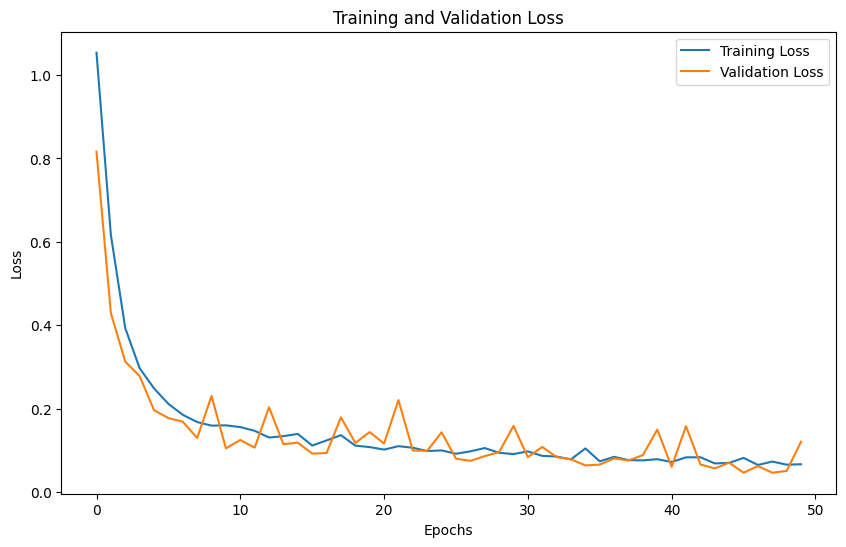

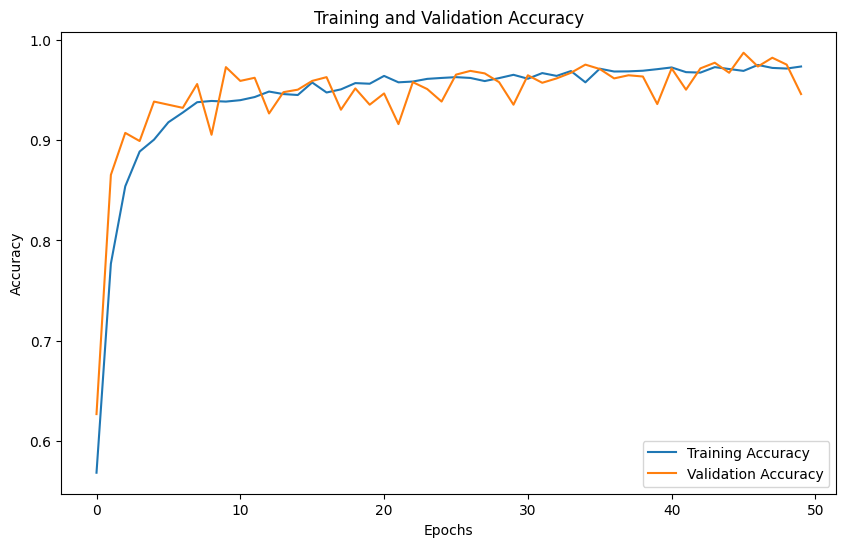

Epoch 1/50


/Users/ChristineDing /Automated_Reporting/tf_env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - accuracy: 0.4783 - loss: 1.3417 - val_accuracy: 0.6266 - val_loss: 0.8160
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.7401 - loss: 0.7104 - val_accuracy: 0.8655 - val_loss: 0.4286
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.8441 - loss: 0.4166 - val_accuracy: 0.9074 - val_loss: 0.3124
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.8826 - loss: 0.3188 - val_accuracy: 0.8993 - val_loss: 0.2777
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.8894 - loss: 0.2698 - val_accuracy: 0.9387 - val_loss: 0.1960
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.9206 - loss: 0.2084 - val_accuracy: 0.9356 - val_loss: 0.1770
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.9309 - loss: 0.1825 - val_accuracy: 0.9325 - val_loss: 0.1685
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.9360 - loss: 0.1680 - val_accurac

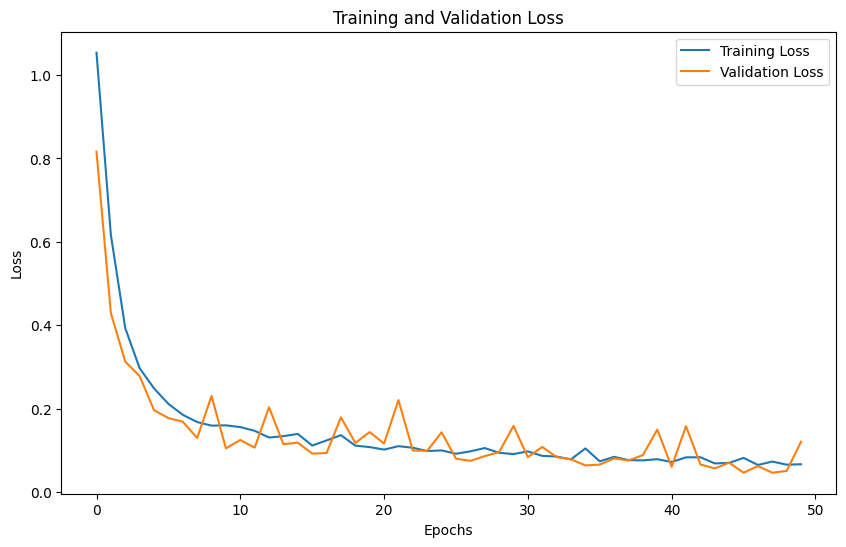

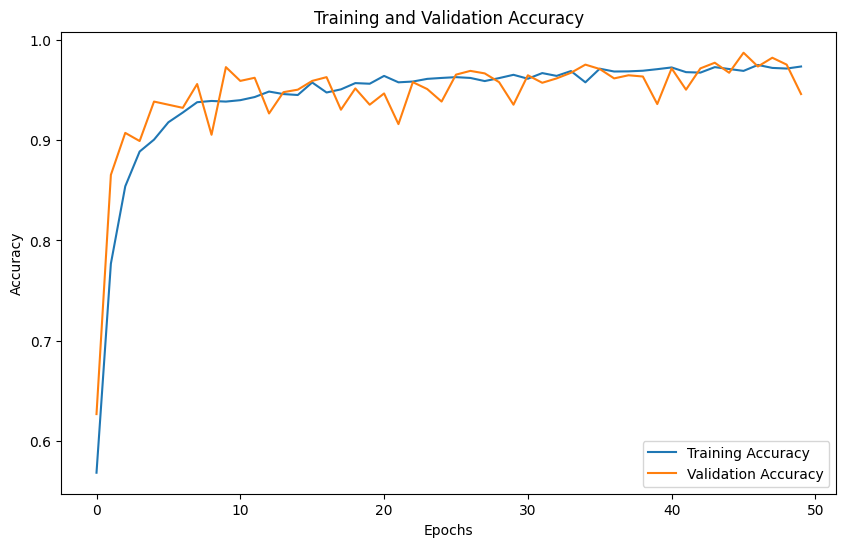